# Alternative Splicing in MD

In [4]:
from transvis.io import *
from transvis.alterSplice import *
from transvis.utils import *
initDB()

In [9]:
# you can set this up to 2**64 if you want everything processed, or less for debugging.
processedNo = 2**64

In [10]:
from intervaltree import Interval, IntervalTree
intervaltrees = {}


# We're going to iterate through all probesets, and retrive from the annotation metadata corresponding to each probeset the probeset location, expressed in genomic coordinates with GRCh37 as the reference genome.

## Takes about 5 minutes

In [10]:
currentIter = transIter()

allchr = set()

# ml := metadataLookup
ml = {key : value for key, value in zip(metadataKeys(), range(len(metadataKeys())))}
for _, transID in zip(range(processedNo), currentIter):
    probesets = transToProbeset(transID)
    for probeset in probesets:
        metadata = probesetAnnotationMetadata(probeset)
        seqname = metadata[ml['seqname']]
        strand = metadata[ml['strand']]
        seqname += strand
        if re.findall("^chr*", seqname):
            allchr.add(seqname)
            if seqname not in intervaltrees:
                t = IntervalTree()
                intervaltrees[seqname] = t
            else:
                t = intervaltrees[seqname]
            start = metadata[ml['start']]
            stop = metadata[ml['stop']]
            try:
                start = int(start)
                stop = int(stop)
            except ValueError:
                continue
            if start == 0 or stop == 0:
                continue
            t[start:stop] = probeset

# Then, we'll iterate through all genecode transcripts, and use the Binary Interval Tree, to find those probesets, which are strictly contained within exons belonging to these transcripts.

## Takes another 5 minutes

In [59]:
for c in allchr:
    c = c[:-1]
    for genecodeI, genecode in zip(range(processedNo), genecodeIter(c)):
        for transcriptI, transcript in enumerate(genecode):
            typ = transcript[0]
            chromosome = transcript[1]
            suffix = transcript[2]
            seqname = chromosome + suffix
            if typ == "exon":
                key = transcript[-1]
                start = int(transcript[3])
                stop = int(transcript[4])
                setGenecodeGenenameBoundary(key, chromosome, suffix, start, stop)
                result = intervaltrees[seqname].search(start, stop, strict=True)
                if result:
                    for interval in result:
                        probeset = interval.data
                        setGenecodeGenenameToProbeset(key, probeset)


# For example all MBNL1's exons strictly contain the following probesets.

In [46]:
from transvis.io import *
from transvis.alterSplice import *
from transvis.utils import *
initDB()
getGenecodeGenenameToProbeset("MBNL1")

{'2648142',
 '2648143',
 '2648146',
 '2648147',
 '2648158',
 '2648159',
 '2648160',
 '2648161',
 '2648167',
 '2648174',
 '2648175',
 '2648178',
 '2648180',
 '2648181',
 '2648184',
 '2648185',
 '2648186',
 '2648194',
 '2648197',
 '2648199',
 '2648200',
 '2648201',
 '2648202',
 '2648203',
 '2648204',
 '2648205'}

# For the visualisation tool we also record the genomic coordinates of each gene


In [47]:
getGenecodeGenenameBoundary("MBNL1")

[151961617, 152183569, 'chr3', '+']

In [48]:
genecodeHGNC = set(d(i).split("$")[-1] for i in redisConn["genecode"].keys("genename$probeset$*"))

In [49]:
properHGNC = set()

In [50]:
with open("CEL_files/HGNC_names.txt") as f:
    for line in f:
        properHGNC.add(line.strip())

# The file HGNC_names.txt contains all legal HGNC names, as per the HGNC website. As one can see, there are 40938 genes in total in this reference database

In [51]:
len(properHGNC)

40938

# Our method of using genecode identifies over 43 thousand genes.

In [52]:
len(genecodeHGNC)

43705

# Let us narrow down to the genes at the intersection of these gene lists. (potentialy caveat: genecode could be using a slightly different nomenclature...)

In [53]:
genesToInvest = properHGNC.intersection(genecodeHGNC)

In [54]:
len(genesToInvest)

28898

In [55]:
distribution = [len(getGenecodeGenenameToProbeset(i)) for i in genesToInvest]

In [56]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [57]:
len([i for i in distribution if i > 400])

1

In [58]:
for i in genesToInvest:
    probesets = getGenecodeGenenameToProbeset(i)
    if len(probesets) > 400:
        print(i)

TTN


# That for example is a histogram of probesets/gene. The gene with the highest number of probesets is titin (which is actually a very interesting gene/protein, and a sensible answer)

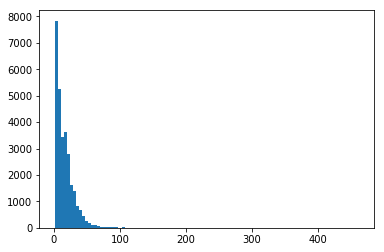

In [59]:
ax1 = plt.subplot()
_ = ax1.hist(distribution, bins=100)

In [60]:
# We can zoom in to discover how many genes have outragesouly few probes (I suggest we resign from all genes with < 4 probes).

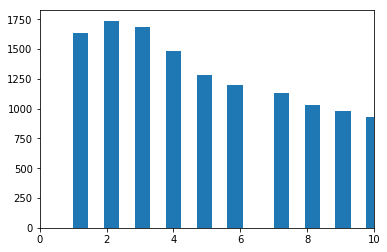

In [61]:
ax1 = plt.subplot()
ax1.hist(distribution, bins=1000)
_ = ax1.set_xlim([0, 10])

# Just to be sure, let's check how large are the "windows" we're going to look at our genes through

In [62]:
windows = [(gene, getGenecodeGenenameBoundary(gene)) for gene in genesToInvest]

In [63]:
windowsSize = [(stop - start, start, stop, gene, chromosome, strand) for gene, (start, stop, chromosome, strand) in windows]

In [64]:
windowsSize.sort()

# Then, let's check if there are any genes, which were incorrectly assigned very large windows.

In [65]:
windowsSize[-20:]

[(1697917, 78636716, 80334633, 'NRXN3', 'chr14', '+'),
 (1743269, 75955846, 77699115, 'ROBO2', 'chr3', '+'),
 (1783651, 67672276, 69455927, 'CTNNA3', 'chr10', '-'),
 (1825171, 55562531, 57387702, 'PCDH15', 'chr10', '-'),
 (1900278, 140988992, 142889270, 'LRP1B', 'chr2', '-'),
 (1987242, 64429876, 66417118, 'EYS', 'chr6', '-'),
 (2057827, 13976015, 16033842, 'MACROD2', 'chr20', '+'),
 (2059619, 2792875, 4852494, 'CSMD1', 'chr8', '-'),
 (2172911, 83166055, 85338966, 'DLG2', 'chr11', '-'),
 (2241764, 31115794, 33357558, 'DMD', 'chrX', '-'),
 (2298477, 8314246, 10612723, 'PTPRD', 'chr9', '-'),
 (2304996, 145813094, 148118090, 'CNTNAP2', 'chr7', '+'),
 (24961288, 29558488, 54519776, 'LINC01598', 'chr12', '-'),
 (95897243, 59208305, 155105548, 'DPH3P2', 'chrX', '+'),
 (95897327, 59311663, 155208990, 'ELOCP24', 'chrX', '-'),
 (95897873, 59318041, 155215914, 'TRPC6P', 'chrX', '-'),
 (95901878, 59353497, 155255375, 'WASH6P', 'chrX', '+'),
 (95910230, 59330252, 155240482, 'IL9R', 'chrX', '+'),
 

# Some reading suggests that everything larger than CNTNAP2 is due to errors in our annotation methodology or genecode and should not be included. (LINC01598 maybe isn't, but it's non-coding anyway)

In [66]:
maxWindowSizeThreshold = 5000000

In [67]:
minProbesetSize = 4

In [68]:
cleanedUpGenes = []

In [69]:
for gene in genesToInvest:
    start, stop, chromosome, strand = getGenecodeGenenameBoundary(gene)
    if stop - start > maxWindowSizeThreshold:
        continue
    if len(getGenecodeGenenameToProbeset(gene)) < minProbesetSize:
        continue
    cleanedUpGenes.append(gene)

# This leaves us with 23827 genes to look at

In [70]:
len(cleanedUpGenes)

23827

# These functions are adapted from the earlier version of the pipeline.

In [334]:
def pValueForProbeset(probeData, ma = None):
    """
    computes the AS-statistic and the corresponing left and right p-value.
    """
    left_pvalues = []
    right_pvalues = []
    if not ma:
        ma = modalAllele()
    for data in probeData:
        regressR = linregress(ma, data)
        left_pvalues.append(regressR.leftpvalue)
        right_pvalues.append(regressR.rightpvalue)
    leftresult = productCDF(product(left_pvalues), len(left_pvalues))
    rightresult = productCDF(product(right_pvalues), len(right_pvalues))
    return min(leftresult, rightresult) * 2

In [335]:
def correctedData(gene, shuffleMA = False):
    """
    computes the average gene expression correction.
    """
    probesets = getGenecodeGenenameToProbeset(gene)
    allPatientsGenes = [[] for _ in modalAllele()]
    patientCorrections = []
    for probeset in probesets:
        for patientNo, probesetD in enumerate(probesetPatientData(probeset)):
            for probeD in probesetD:
                allPatientsGenes[patientNo].append(probeD)
    for patientD in allPatientsGenes:
        patientCorrections.append(sum(patientD)/len(patientD))
    resultData = {}
    pValues = {}
    modalA = [i for i in modalAllele()]
    if shuffleMA:
        random.shuffle(modalA)
    for probeset in probesets:
        newData = []
        for oldData in probesetData(probeset):
            newData.append([point - correction for point, correction in zip(oldData, patientCorrections)])
        resultData[probeset] = newData
        pValue = pValueForProbeset(newData, ma = modalA)
        pValues[probeset] = pValue
    return (pValues, resultData)

# An interesting observation, which shows that values greater that `0.9**4` are less likely than values less than `0.1**4` under the product distribution with 4 degrees of freedom.

However, this won't influence our results, as the "intermediate" p-values we're using always come in pairs, `p` and `1-p`. After computing the product, we always take the smallest one, which makes the result consistent for both upregulated and downregulated exons.

In [293]:
print(1 - productCDF(0.9**4, 4))
print(productCDF(0.1**4, 4))

0.000940523891325
0.0182844955163


# Here we double-check that productCDF works (we expect answer to be close to 0.5)

In [295]:
k = 0
v = 10
for i in range(v):
    k += productCDF(product([random.uniform(0, 1) for i in range(4)]), 4)
print(k/v)

0.526882130193


In [296]:
import random
geneData = {}
for _, gene in zip(range(10), cleanedUpGenes):
    geneData[gene] = correctedData(gene)[0]

# Here we repeat the process of alternative splicing discovery from the previous pipeline, but this time using a null distribution.

In [78]:
nakamoriGenes = set()

with open("geneList") as f:
    for line in f:
        if not line:
            continue
        if line [0] == "#":
            continue
        gene = line.split(",")[0]
        nakamoriGenes.add(gene)

nakamoriNo = len(nakamoriGenes)
commonGenes = nakamoriGenes.intersection(allOurGenes)
agreedWith = len(commonGenes)

# We begin by counting how many probesets we have to look at.

In [304]:
probesetCount = 0

for gene in cleanedUpGenes:
    probesetCount += len(getGenecodeGenenameToProbeset(gene))
probesetCount

442050

# We can then carry out the simulation to retrieve a "real" or "final" p-value.

In [395]:
redisConn["alterSplice"].delete("simProbesets")

1

In [397]:
import random
import time
start = time.time()
for i in range(10):
    for _, gene in zip(range(2**64), cleanedUpGenes):
        interPValues = correctedData(gene, shuffleMA = True)[0]
        for (probeset, interPValue) in interPValues.items():
            key = gene + "$" + probeset + "$" + str(i)
            redisConn["alterSplice"].zadd("simProbesets", interPValue, key)
stop = time.time()
print(stop - start)

5710.0147793293


# As you can see, real p-values lose about 5 orders of magnitude.

In [398]:
def realPValue(interPValue):
    lessThan = redisConn["alterSplice"].zcount("simProbesets", min="-inf", max=interPValue)
    total = redisConn["alterSplice"].zcount("simProbesets", min="-inf", max="+inf")
    return lessThan/total

print(realPValue(10**(-10)))
print(realPValue(10**(-8)))

5.5649813369528334e-05
0.0002397918787467481


# And finally we can run the experiment again

In [399]:
redisConn["alterSplice"].delete("simGeneAS")

0

In [400]:
start = time.time()
for _, gene in zip(range(2**64), cleanedUpGenes):
    interPValues = correctedData(gene)[0]
    for (probeset, interPValue) in interPValues.items():
        redisConn["alterSplice"].zadd("simGeneAS", realPValue(interPValue), gene + "$" + probeset)
stop = time.time()
print(stop - start)

609.6890335083008


In [423]:
redisConn["alterSplice"].zrange("simGeneAS", 0, 20, withscores=True)

[(b'ABLIM1$3307988', 4.524375070693361e-06),
 (b'ARHGEF9$4010527', 8.143875127248049e-06),
 (b'ABLIM1$3308051', 1.4478000226218754e-05),
 (b'ARHGAP5$3531485', 1.5382875240357426e-05),
 (b'RAPH1$2595566', 1.6966406515100102e-05),
 (b'ARHGAP5$3531527', 1.7192625268634768e-05),
 (b'ABLIM1$3308076', 1.7871281529238773e-05),
 (b'ABLIM1$3307940', 1.945481280398145e-05),
 (b'PKP2$3450255', 1.9907250311050785e-05),
 (b'TBX3$3472764', 1.9907250311050785e-05),
 (b'ABLIM1$3308075', 2.0133469064585454e-05),
 (b'ABLIM1$3308001', 2.171700033932813e-05),
 (b'ABLIM1$3308034', 2.375296912114014e-05),
 (b'ABLIM1$3308091', 2.420540662820948e-05),
 (b'ABLIM1$3307961', 2.488406288881348e-05),
 (b'ARHGAP5$3531521', 2.8729781698902838e-05),
 (b'NFIX$3822162', 2.9634656713041512e-05),
 (b'TBX3$3472777', 3.1444406741318854e-05),
 (b'PKP2$3450266', 3.2349281755457525e-05),
 (b'ABLIM1$3307963', 3.3027938016061534e-05),
 (b'ARHGAP5$3531482', 3.3027938016061534e-05)]

# In order to compare it with the result of the previous version of the pipeline we can take top 800 probesets and see how different the results are (just a sanity check)

In [402]:
allOurGenes = set()
for geneProbesetScore in redisConn["alterSplice"].zrange("simGeneAS", 0, 800, withscores=True):
    geneProbeset, score = geneProbesetScore
    gene, probeset = d(geneProbeset).split("$")
    allOurGenes.add(gene)

In [403]:
print(allOurGenes)

{'CHIC2', 'LIMCH1', 'CCDC14', 'F8', 'ZNF675', 'CDC42P3', 'TUBB1', 'SMAD2', 'STK24P1', 'LARP7', 'SGMS2', 'ZNF382', 'TMEM183A', 'ZNF667', 'CDNF', 'ZNF827', 'RAP1A', 'CCDC17', 'TBCD', 'GUSBP2', 'SEPT7P3', 'ZNF93', 'TBC1D23', 'LGR5', 'LRIG3', 'ZNF75A', 'CEP112', 'VPS35P1', 'ZNF721', 'FHOD1', 'RPGR', 'CILP', 'PAFAH1B2', 'SSFA2', 'MBD5', 'SAMD4A', 'MAP7D3', 'PPIC', 'CHMP5', 'ARHGAP5', 'ZNF778', 'CFHR1', 'PLPP1', 'C18orf32', 'NFIA', 'LIMS4', 'EOGT', 'EEF1A1P32', 'PHC3', 'NPIPB15', 'CHP1', 'ARHGEF9', 'ZDHHC2', 'TENM1', 'GUSBP1', 'SLC7A10', 'ABHD2', 'DMTF1', 'RPL23AP87', 'ATP11B', 'PDZD11', 'WASHC4', 'NF1', 'TBX3', 'ZNF626', 'NEDD4L', 'TBCK', 'HELZ', 'ABLIM1', 'DLG1', 'MTMR2', 'HMBOX1', 'NFIX', 'SOCS4', 'GLULP3', 'KCNQ1OT1', 'ZNF493', 'TTLL5', 'DIS3', 'SERF2', 'TM9SF2', 'STK3', 'PTPRD', 'RCBTB1', 'ZNF85', 'OFD1', 'PANK3', 'UBLCP1', 'EEF1A1P33', 'HMGB1', 'FGFRL1', 'FOXD4L1', 'SATB2', 'TPTE2', 'BPTF', 'TFPI', 'ZNF682', 'WDR75', 'RASA1', 'AATF', 'ZNF184', 'LNPEP', 'POLR1D', 'LINC00431', 'H3F3A', '

In [411]:
nakamoriGenes = set()
with open("geneList") as f:
    for line in f:
        if not line:
            continue
        if line [0] == "#":
            continue
        gene = line.split(",")[0]
        nakamoriGenes.add(gene)

nakamoriNo = len(nakamoriGenes)
commonGenes = nakamoriGenes.intersection(allOurGenes)
agreedWith = len(commonGenes)

In [412]:
commonGenes

{'ATP2A2', 'CLCN1', 'FHOD1', 'LDB3', 'MBNL2', 'NFIX', 'TBC1D15'}

# We still agree on 7 genes, but this time ATP2A2 makes it to the list, while MBNL1 doesn't.

# We can also look at the zinc fingers hypothesis.

In [406]:
[x, M, n, N] = [agreedWith - 1, len(cleanedUpGenes), nakamoriNo , len(allOurGenes)]
scipy.stats.hypergeom.sf(x, M, n, N)

1.0

In [407]:
geneExpression = set()
with open("geneExpression") as ge:
    for line in ge:
        for elem in line.rstrip().split():
            geneExpression.add(elem)

In [408]:
commonGE = allOurGenes.intersection(geneExpression)
print(len(allOurGenes))
print(len(geneExpression))
print(len(commonGE))
[x, M, n, N] = [len(commonGE) - 1, len(cleanedUpGenes), len(geneExpression) , len(allOurGenes)]
scipy.stats.hypergeom.sf(x, M, n, N)

321
877
25


0.00037788473593942858